In [2]:
# 利用其中的API
import os
# 用于查找文件目录和文件
import glob
# 高级的文件、文件夹、压缩包处理模块
import random
import shutil
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# 作统计表
import seaborn as sns
# 统计学习横截面模型和方法
import statsmodels.api as sm
# 使用公式字符串和DataFrame指定模型的方便接口
import statsmodels.formula.api as smf
# 统计推断：卡方，正态，t等
from scipy import stats
# sklearn机器学习库
# 评价指标函数：均方误差
from sklearn.metrics import mean_absolute_error  # 平方绝对误差
# 数据标准化函数
from sklearn.preprocessing import scale
# 随机森林
from sklearn.ensemble import RandomForestRegressor
# 线性回归
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

# 设置显示宽度
pd.set_option('display.width', 1000)

In [3]:
os.chdir(r'D:\\老师的课堂PPT\\大三上\\金融科技\\第一次作业')  # 修改工作目录
path = os.getcwd()  # 获取工作目录

# 设置因子保留的起止年份
startyear = 1997
endyear = 2019

# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 第一题
# 读取上市公司信息文件
stock = open(os.path.join(path, '数据', 'TRD_Co.csv'), 'r+', encoding='gbk')  # 路径拼接函数
stock = pd.read_csv(stock)
stock.head()

# 保留所有A股，修改所有上市年份的格式:1991/4/3 ——> 1991
stock = stock[stock['Markettype'].isin([1, 4, 16, 32])]  # 删除原表格第2，3行说明文字，否则默认都读成字符串格式
stock['listyear'] = stock['Listdt'].apply(lambda x: float(x[:4]))  # apply相当于循环遍历，起到对DataFrame每一条数据进行处理的效果
stock = stock[stock['listyear'] <= endyear]
stock['stkcd'] = stock['Stkcd'].apply(lambda x: str(int(x)).zfill(6))
stks = pd.DataFrame(columns=stock['stkcd'])
print(stks)

# 个股收益率原始文件
retm = open(os.path.join(path, '数据', 'TRD_Mnth.csv'), 'r+', encoding='gbk')
retm = pd.read_csv(retm)
retm.head()

# 整理格式
retm['month'] = retm['Trdmnt'].apply(lambda x: x[:4] + x[5:7])  # 1991-04 ——> 199104
retm = retm[['Stkcd', 'month', 'Mretwd', 'Msmvosd', 'Msmvttl']]
retm = retm.astype(float)
retm.columns = ['stkcd', 'month', 'return', 'mktcap', 'mktcap_ttl']
retm['stkcd'] = retm['stkcd'].apply(lambda x: str(int(x)).zfill(6))
retm['return'] = retm['return'] * 100
retm['mktcap'] = retm['mktcap'] * 1000
retm['mktcap_ttl'] = retm['mktcap_ttl'] * 1000  # 原文件市值单位是千
retm = pd.merge(stock['stkcd'], retm, on='stkcd', how='left')  # 组合两数据框（以只保留A股）
retm.head()

# 保留月份池
mths = pd.DataFrame(index=retm['month'].drop_duplicates().sort_values())

# 打印问题一答案
print("万科2019年1月的股票收益：{}".format(
    retm[(retm['stkcd'] == '000002') & (retm['month'] == 201901)]['return'].values[0]))  # stkcd为str,month为float
print("万科2018年12月的流通市值：{}".format(retm[(retm['stkcd'] == '000002') & (retm['month'] == 201812)]['mktcap'].values[0]))


Empty DataFrame
Columns: [000001, 000002, 000003, 000004, 000005, 000006, 000007, 000008, 000009, 000010, 000011, 000012, 000013, 000014, 000015, 000016, 000017, 000018, 000019, 000020, 000021, 000022, 000023, 000024, 000025, 000026, 000027, 000028, 000029, 000030, 000031, 000032, 000033, 000034, 000035, 000036, 000037, 000038, 000039, 000040, 000042, 000043, 000045, 000046, 000047, 000048, 000049, 000050, 000055, 000056, 000058, 000059, 000060, 000061, 000062, 000063, 000065, 000066, 000068, 000069, 000070, 000078, 000088, 000089, 000090, 000096, 000099, 000100, 000150, 000151, 000153, 000155, 000156, 000157, 000158, 000159, 000166, 000301, 000333, 000338, 000400, 000401, 000402, 000403, 000404, 000405, 000406, 000407, 000408, 000409, 000410, 000411, 000412, 000413, 000415, 000416, 000417, 000418, 000419, 000420, ...]
Index: []

[0 rows x 3873 columns]
万科2019年1月的股票收益：16.4987
万科2018年12月的流通市值：231415350400.0


In [6]:
# 问题二
balan = open(os.path.join(path, '数据', 'FS_Combas.csv'), 'r+', encoding='gbk')
profi = open(os.path.join(path, '数据', 'FS_Comins.csv'), 'r+', encoding='gbk')
balan = pd.read_csv(balan)
profi = pd.read_csv(profi)
fin_data = pd.merge(balan, profi, on=['Stkcd', 'Accper', 'Typrep'], how='left')
fin_data.to_csv(os.path.join(path, '数据', 'Finance_Data.csv'), index=False, header=False)

# 数据处理
fin_data = fin_data[fin_data['Typrep'] == 'A']  # 只保留合并报表
fin_data['stkcd'] = fin_data['Stkcd'].apply(lambda x: str(int(x)).zfill(6))
fin_data['month'] = fin_data['Accper'].apply(lambda x: float(x[:4] + x[5:7]))
fin_data = fin_data.iloc[:, 3:]  # 删除掉无用的前三列(行，3-最后所有列)
fin_data = fin_data[fin_data['month'] % 100 != 1]  # 删除一月的数据:1月1日与12月31日的数值近似，使用原始数据不考虑1月数据。
fin_data = fin_data[~fin_data['month'].isin([199306, 199406, 199703, 200109])]  # 缺失严重(~布尔值取反,删除这些月份)?
fin_data = fin_data.replace('', np.nan)

fin_data.head()

# 财报月份池
mths_sheet = pd.DataFrame(index=fin_data['month'].drop_duplicates().sort_values())


# 定义函数，保留所需股票，补充月份
def expand_data(asset, stks, mths):
    asset = pd.concat([stks, asset], axis=0, join='inner', sort=False)
    asset = pd.concat([stks, asset], axis=0, join='outer', sort=False)
    asset = pd.concat([mths, asset], axis=1, join='outer', sort=False)
    return asset


# 总资产
asset = fin_data[['stkcd', 'month', 'A001000000']]
asset = asset.pivot_table(values='A001000000', index=['month'], columns=['stkcd'])
asset = expand_data(asset, stks, mths_sheet)
asset.head()

# 问题二结果
print("2019年12月所有上市公司资产总计的描述性统计：\n{}".format(
    asset.loc[201912, :].astype(float).describe()))
print("样本数：{}".format(len(asset.loc[201912, :])))
print("缺失值个数：{}".format(asset.loc[201912, :].isnull().sum()))


2019年12月所有上市公司资产总计的描述性统计：
count    3.756000e+03
mean     7.471478e+10
std      9.394415e+11
min      4.166936e+07
25%      1.879874e+09
50%      4.132845e+09
75%      1.087265e+10
max      3.010940e+13
Name: 201912.0, dtype: float64
样本数：3873
缺失值个数：117


In [12]:
# 描述性统计分析新冠疫情期间公司资产方面受到的冲击
pd.concat([
asset.loc[201906, :].astype(float).describe(),
asset.loc[201909, :].astype(float).describe(),
asset.loc[201912, :].astype(float).describe(),
asset.loc[202003, :].astype(float).describe(),
asset.loc[202006, :].astype(float).describe(),
asset.loc[202009, :].astype(float).describe(),], axis=1, join='inner', sort=False)


,201906.0,201909.0,201912.0,202003.0,202006.0,202009.0
count,3.648000e+03,3.695000e+03,3.756000e+03,3.756000e+03,3.746000e+03,3.745000e+03
mean,7.060925e+10,7.104257e+10,7.471478e+10,7.815986e+10,8.016124e+10,8.190016e+10
std,9.132010e+11,9.227070e+11,9.394415e+11,9.946814e+11,1.015451e+12,1.035331e+12
min,2.712710e+07,2.684155e+07,4.166936e+07,3.880334e+07,3.433052e+07,3.213259e+07
25%,1.830045e+09,1.881352e+09,1.879874e+09,1.874894e+09,1.909749e+09,1.979897e+09
50%,4.170959e+09,4.197032e+09,4.132845e+09,4.113950e+09,4.195556e+09,4.317475e+09
75%,1.085017e+10,1.087228e+10,1.087265e+10,1.099138e+10,1.124350e+10,1.167299e+10
max,2.999050e+13,3.042640e+13,3.010940e+13,3.209450e+13,3.311200e+13,3.347190e+13


In [13]:
# 问题三：缺失值填充为横截面均值
# 描述性统计函数
def describe_data(asset):
    des = []  # 资产总计描述性统计
    for i in range(asset.shape[0]):  # 98个月
        des.append(asset.iloc[i, :].astype(float).describe())
    des = np.mean(pd.DataFrame(des), axis=0)  # (所有公司)98个月——>(所有公司)整段时间（按行计算，得到列的性质）
    num_sam = np.mean(asset.shape[1])
    num_nan = np.mean(asset.isnull().sum(axis=1))
    return des, num_sam, num_nan


# 描述性统计
des_asset, num_sam_asset, num_nan_asset = describe_data(asset)
print("上市公司资产总计的描述性统计：\n{}".format(des_asset))
print("平均样本个数：{}".format(num_sam_asset))
print("平均缺失个数：{}".format(num_nan_asset))

# 向前法数据填充
assetf = asset.fillna(method='ffill')
des_assetf, num_sam_assetf, num_nan_assetf = describe_data(assetf)
print("上市公司资产总计的描述性统计(数据填充后)：\n{}".format(des_assetf))
print("平均样本个数(数据填充后)：{}".format(num_sam_assetf))
print("平均缺失个数(数据填充后)：{}".format(num_nan_assetf))  # 此法填充空缺数仍不为0

# 截面均值填充
assetm = pd.DataFrame(columns=asset.columns, index=asset.index)
mean_cross = list(asset.mean(axis=1))
for i in range(asset.shape[0]):
    assetm.iloc[i, :] = asset.iloc[i, :].fillna(mean_cross[i])
des_assetm, num_sam_assetm, num_nan_assetm = describe_data(assetm)
print("上市公司资产总计的描述性统计(截面均值填充)：\n{}".format(des_assetm))
print("平均样本个数(截面均值填充)：{}".format(num_sam_assetm))
print("平均缺失个数(截面均值填充)：{}".format(num_nan_assetm))

# 截面中值填充
assetmd = pd.DataFrame(columns=asset.columns, index=asset.index)
median_cross = list(asset.median(axis=1))
for i in range(asset.shape[0]):
    assetmd.iloc[i, :] = asset.iloc[i, :].fillna(median_cross[i])
des_assetmd, num_sam_assetmd, num_nan_assetmd = describe_data(assetmd)
print("上市公司资产总计的描述性统计(截面中值填充)：\n{}".format(des_assetmd))
print("平均样本个数(截面中值填充)：{}".format(num_sam_assetmd))
print("平均缺失个数(截面中值填充)：{}".format(num_nan_assetmd))

上市公司资产总计的描述性统计：
count    1.943898e+03
mean     3.315848e+10
std      4.142191e+11
min      3.214429e+07
25%      1.098487e+09
50%      2.267736e+09
75%      5.470339e+09
max      1.221969e+13
dtype: float64
平均样本个数：3873.0
平均缺失个数：1929.1020408163265
上市公司资产总计的描述性统计(数据填充后)：
count    2.041347e+03
mean     3.305273e+10
std      4.186858e+11
min      2.255345e+07
25%      1.069577e+09
50%      2.234943e+09
75%      5.462168e+09
max      1.257886e+13
dtype: float64
平均样本个数(数据填充后)：3873.0
平均缺失个数(数据填充后)：1831.6530612244899
上市公司资产总计的描述性统计(截面均值填充)：
count    3.873000e+03
mean     3.315848e+10
std      3.511400e+11
min      3.214429e+07
25%      2.189802e+09
50%      9.310031e+09
75%      2.262496e+10
max      1.221969e+13
dtype: float64
平均样本个数(截面均值填充)：3873.0
平均缺失个数(截面均值填充)：0.0
上市公司资产总计的描述性统计(截面中值填充)：
count    3.873000e+03
mean     2.481002e+10
std      3.513788e+11
min      3.214429e+07
25%      1.649046e+09
50%      2.267736e+09
75%      3.676034e+09
max      1.221969e+13
dtype: float64
平均样本个数(截面中值填充)

In [27]:
q3 = pd.concat([pd.DataFrame(des_assetm),pd.DataFrame(des_assetmd)], axis=1, join='inner', sort=False)
q3.columns = ['截面均值填充', '截面中值填充']

q3

,截面均值填充,截面中值填充
count,3.873000e+03,3.873000e+03
mean,3.315848e+10,2.481002e+10
std,3.511400e+11,3.513788e+11
min,3.214429e+07,3.214429e+07
25%,2.189802e+09,1.649046e+09
50%,9.310031e+09,2.267736e+09
75%,2.262496e+10,3.676034e+09
max,1.221969e+13,1.221969e+13


In [34]:
# 第四题：查看万科公司的动量、AM值
# 无风险利率数据
rf = open(os.path.join(path, '数据', 'TRD_Nrrate.csv'), 'r+', encoding='utf-8')
rf = pd.read_csv(rf)
rf['month'] = rf['Clsdt'].apply(lambda x: float(x[:4] + x[5:7]))  # 转化月份格式，将其变为index
rf = rf[['month', 'Nrrmtdt']]
rf.columns = ['month', 'rf']
rf = rf.drop_duplicates('month').set_index('month')
rf.head()  # %为单位

# ff五因子数据
ff5 = open(os.path.join(path, '数据', 'STK_MKT_FIVEFACMONTH.csv'), 'r+', encoding='utf-8')
ff5 = pd.read_csv(ff5)
ff5 = ff5[ff5['MarkettypeID'] == 'P9714']  # 保留综合A股、创业板、科创板
ff5 = ff5[ff5['Portfolios'] == 1]  # 2*3投资组合划分方法
ff5['month'] = ff5['TradingMonth'].apply(lambda x: float(x[:4] + x[5:7]))
ff5 = ff5[['month', 'RiskPremium1', 'SMB1', 'HML1', 'RMW1', 'CMA1']].astype(float)
ff5.columns = ['month', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma']  # (风险溢价、市值、账面市值、盈利、投资)五因子
ff5 = ff5.sort_values(by='month').set_index('month')
ff5 = ff5 * 100
ff5 = pd.concat([ff5, rf], axis=1, join='inner')
ff5.head()

# 股票池A，全A股
retA = retm[['stkcd', 'month', 'return']]
retA = pd.merge(retA, rf, how='left', on=['month'], sort=False)
retA['ret'] = retA['return'] - retA['rf']
retA = retA.pivot_table(values='ret', index=['month'], columns=['stkcd'])
retA = expand_data(retA, stks, mths)
retA = retA[(retA.index >= startyear * 100) & (retA.index <= endyear * 100 + 12)]
retA.head()

# 创建文件夹保存过程数据
out_path = os.path.join(path, '过程数据')
if not os.path.exists(out_path):
    os.mkdir(out_path)

retA.to_csv(os.path.join(path, '过程数据', 'retA.csv'))
retA = pd.read_csv(os.path.join(path, '过程数据', 'retA.csv'), header=0, index_col=0)  # 第一行/列作为行/列名


# 计算市值size
def get_size(data):
    data = data.astype(float)
    data['stkcd'] = data['stkcd'].apply(lambda x: str(int(x)).zfill(6))
    data = data.pivot_table(values=data.columns[-1], index=['month'], columns=['stkcd'])
    data = expand_data(data, stks, mths)
    data = data[(data.index >= (startyear - 1) * 100 + 12) & (data.index <= endyear * 100 + 12)]
    return data


# size
size = retm[['stkcd', 'month', 'mktcap']]  # 流通市值
size = get_size(size)
size.head()

size.to_csv(os.path.join(path, '过程数据', 'size.csv'))
size = pd.read_csv(os.path.join(path, '过程数据', 'size.csv'), header=0, index_col=0)

# mom:过去6个月的累计收益率：要求：至少过去5个月有数据，否则不予计算，且跳过最近一个月的数据
# 例：200012的动量是200007、08、09、10、11的数据算出来的，用于对200101排序
ret_mom = retm[['stkcd', 'month', 'return']]
ret_mom = ret_mom.pivot_table(values='return', columns=['stkcd'], index=['month'])
ret_mom = expand_data(ret_mom, stks, mths)
ret_mom = ret_mom / 100 + 1
ret_mom = ret_mom[ret_mom.index > 199600]

In [40]:
# 动量至少过去5个月有数据，否则不予计算，赋NA值
def get_mom(data, n, minimum):
    # data=ret_mom
    # n,minimum=5,5
    months = data.index
    month = months[n:]  # 滞后5个月
    data0 = pd.DataFrame(index=month, columns=data.columns)
    for i, mon in enumerate(month):
        # i=0;i++
        # mon=month[i]
        data1 = data[(data.index >= months[i]) & (data.index < mon)]
        data2 = []  # 此与注释语句对data2,data0操作相同
        for j in range(data1.shape[1]):
            if len(data1.iloc[:, j].dropna()) >= minimum:
                data2.append(np.prod(data1.iloc[:, j]))
            else:  # 有缺失值，总共<5
                data2.append(np.nan)
        data0.iloc[i, :] = data2
        # data2 = data1.apply(lambda x: np.prod(x, axis=0) if len(x.dropna()) >= 5 else np.nan)
        # （为什么len(data1.dropna())得不到数据框？）
        # data0.iloc[i, :] = data2.T.values
        # print(month[i])
    data0 = data0 - 1
    return data0


mom_6 = get_mom(ret_mom, 5, 5)
mom_6 = expand_data(mom_6, stks, mths)
mom_6 = mom_6[(mom_6.index >= (startyear - 1) * 100 + 12) & (mom_6.index < endyear * 100 + 12)]
#mom_6.to_csv(os.path.join(path, '过程数据', 'mom_6.csv'))
#mom_6 = pd.read_csv(os.path.join(path, '过程数据', 'mom_6.csv'), header=0, index_col=0)
mom_6.head()

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688333,688357,688358,688363,688366,688368,688369,688388,688389,688399
199612.0,0.18354,1.71048,2.33248,0.279695,2.25053,1.72889,1.81204,0.87577,1.46035,1.33496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199701.0,0.0462319,0.385664,0.469492,-0.284689,0.693728,0.735632,0.510033,-0.00811289,0.363187,0.070503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199702.0,0.175321,0.397501,0.504146,0.00943435,0.716128,0.952879,1.11208,0.328137,0.327273,0.328903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199703.0,0.178638,0.471054,0.523502,0.193549,1.05074,0.597765,1.16268,0.427535,0.394635,0.413534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199704.0,0.573487,0.405089,0.151833,-0.120162,0.249534,0.614134,1.11351,0.346988,0.0318392,0.569845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# 开始计算五个因子
# AM资产市值比
def get_am(df, keep='一季报'):
    # df=am
    """
    AM=季末总资产/季末流通市值 (总市值mktcap_ttl！=总资产A001)

    一季报（3月）在4月宣；
    二季报（即半年报）（6月）在8月宣；
    三季报（9月）在10月宣；
    四季报（即年报）（12月）在次年4月宣。

    考虑到这一点，需要将计算得到的因子做填充处理：
1. 利用 t 年年报因子数据填充 t+1 年 4-7 月份数据（在 t 年年报数据和 t+1年一季报数据中，年报数据质量更高，所以使用年报数据）；
2. 利用 t+1 年半年报因子数据填充 t+1 年 8-9 月份数据；
3. 利用 t+1 年三季报因子数据填充 t+1 年 10 月~t+2 年 3 月份数据。
    """
    df = df.astype(float)
    df.columns = ['stkcd', 'month', 'value']
    df['stkcd'] = df['stkcd'].apply(lambda x: str(int(x)).zfill(6))
    df.loc[(df['value'] == np.inf) | (df['value'] == -np.inf), 'value'] = np.nan
    df = df.dropna()

    
    # annodt:财报宣告日；将数据对应的实际日期改为滞后日期（即实际得到数据的日期）
    df.loc[(df['month'] % 100 == 3) | (df['month'] % 100 == 9), 'annodt'] = df['month'] + 1  # 第一季（3月）在4月宣，第三季（9月）在10月宣
    df.loc[df['month'] % 100 == 6, 'annodt'] = df['month'] + 2  # 第二季（即半年报）（6月）在8月宣
    df.loc[df['month'] % 100 == 12, 'annodt'] = df['month'] + 100 - 8  # 第四季（即年报）（12月）在次年4月宣

    if keep == '年报':
        df = df[df['month'] % 100 != 3]
    elif keep == '一季报':
        df = df.sort_values(by=['stkcd', 'month'])
        df = df.drop_duplicates(subset=['stkcd', 'annodt'], keep='last')

    # 长变宽表
    df = df.pivot_table(values='value', index=['annodt'], columns=['stkcd'])
    # 选定所需日期和所需股票
    df = expand_data(df, stks, mths)
    # 处理缺失值，ffill用前一个值填充，即[已知宣告数据-下一个宣告数据)
    df = df.fillna(method='ffill', limit=11)  # 最多往后填充11个月，为了避免使用过早的数据
    df = df[(df.index >= (startyear - 1) * 100 + 12) & (df.index < endyear * 100 + 12)]

    
    return df


am = pd.merge(retm[['stkcd', 'month', 'mktcap']], fin_data[['stkcd', 'month', 'A001000000']], on=['stkcd', 'month'],
              how='inner').astype(float)
am['am'] = am['A001000000'] / am['mktcap']
am = am[['stkcd', 'month', 'am']]
am = get_am(am, keep='一季报')
am.head(10)
# am.to_csv(os.path.join(path, '过程数据', 'am.csv'))

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688333,688357,688358,688363,688366,688368,688369,688388,688389,688399
199612.0,2.222873,3.333779,4.053564,2.947168,3.335400,1.381762,3.119088,1.406793,2.520084,2.224428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199701.0,2.222873,3.333779,4.053564,2.947168,3.335400,1.381762,3.119088,1.406793,2.520084,2.224428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199702.0,2.222873,3.333779,4.053564,2.947168,3.335400,1.381762,3.119088,1.406793,2.520084,2.224428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199703.0,2.222873,3.333779,4.053564,2.947168,3.335400,1.381762,3.119088,1.406793,2.520084,2.224428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199704.0,2.545490,1.912489,2.077948,2.643313,1.204090,0.680442,1.647869,1.134463,1.372881,2.002920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199705.0,2.545490,1.912489,2.077948,2.643313,1.204090,0.680442,1.647869,1.134463,1.372881,2.002920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199706.0,2.545490,1.912489,2.077948,2.643313,1.204090,0.680442,1.647869,1.134463,1.372881,2.002920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199707.0,2.545490,1.912489,2.077948,2.643313,1.204090,0.680442,1.647869,1.134463,1.372881,2.002920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199708.0,1.133167,0.862544,2.236298,2.074215,0.667706,0.875566,0.625550,0.923245,1.362569,1.356210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199709.0,1.133167,0.862544,2.236298,2.074215,0.667706,0.875566,0.625550,0.923245,1.362569,1.356210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# 问题四：万科公司 2019 年 1 月动量、AM 的值
print("万科公司2019年1月mom6的值：{}".format(mom_6.loc[201901, '000002']))
print("万科公司2019年1月am的值：{}".format(am.loc[201901, '000002']))

万科公司2019年1月mom6的值：0.061724063666914734
万科公司2019年1月am的值：6.066707468891128


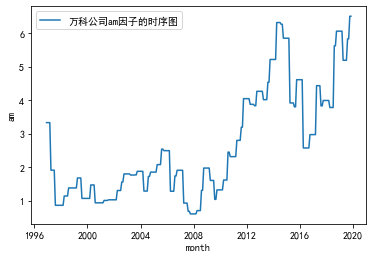

In [13]:
# 问题四：查看万科公司 1996 年 12 月-2019 年 11 月的 AM 分布
# 并作图列出am因子的时序图(x 轴为时间，y 轴为因子)
vk_am = pd.DataFrame(am.loc[:, '000002'])
vk_am = vk_am.reset_index()
vk_am.columns = ['month', 'am']
vk_am
vk_am['month']=pd.to_datetime(vk_am['month'].apply(lambda x:str(x)[:4]+'-'+str(x)[4:-2]),format='%Y-%m-%d')

fig,ax=plt.subplots()
sns.lineplot(x='month',y=vk_am.loc[:,'am'],data=vk_am,label='万科公司am因子的时序图')
plt.show()



In [22]:
# illq:收益率占比交易金额(此因子计算复杂，代码块运行需要十几分钟！)
def get_illq(df):
    """
    过去12个月，日收益率绝对值/日交易金额 x10^6的平均值（不少于120个交易日）
    Dnvaltrd:日个股交易金额
    Dretwd:考虑现金红利再投资的日个股回报率
    """
    # df = ill
    df.columns = ['stkcd', 'date', 'trans_money', 'return']
    df['stkcd'] = df['stkcd'].apply(lambda x: str(int(x)).zfill(6))
    df['date'] = pd.to_datetime(df['date'])
    df['return'] = df['return'] * 100
    df['illq'] = abs(df['return']) / df['trans_money'] * 1e6
    df.loc[(df['illq'] == np.inf) | (df['illq'] == -np.inf), 'illq'] = np.nan  # 相除后有可能出现inf
    df = df.dropna()  # dropna很重要，不然数据处理后会产生更多缺失值，因为na和任何数的运算值为na

    # 长表——>宽表  (注意顺序，需要先长表转宽表，再根据日期填充/合并)
    df = df.pivot_table(values='illq', index=['date'], columns=['stkcd'])

    # 日频——>月频  (取均值，注意是先计算日数据因子值再取均值/不是先取均值整合成月数据再计算因子)
    df = df.reset_index()
    df['month'] = df['date'].apply(lambda x: float(str(x)[:4]+str(x)[5:7]))
    df_month = df.resample('M', on='date').mean()

    # 使用过去12个月的均值，且不少于120个交易日
    df_month = df_month.reset_index()
    df_month = df_month.drop(['date'], axis=1)
    months = df_month['month']
    month = months[12:]
    df_month = df_month.set_index(['month'])

    # illq_final:最终计算得到的illq因子值
    illq_final = pd.DataFrame(index=month, columns=df_month.columns)
    for i, mon in enumerate(month):
        # 取过去12个月的illq数据框（过去12月还是12期？）
        # i=0
        # mon = month[i+12]
        data_12month = df_month[(df_month.index >= months[i]) & (df_month.index < mon)]
        data_120day = df[(df['month'] >= months[i]) & (df['month'] < mon)]
        data_120day = data_120day.set_index('date')
        data2 = []
        for j in range(data_12month.shape[1]):
            # 不少于120个交易日
            # j = 0
            if len(data_120day.iloc[:, j].dropna()) >= 120:
                data2.append((data_12month.iloc[:, j]).mean())
            else:
                data2.append(np.nan)
        illq_final.iloc[i, :] = data2

    # 计算完成，此时开始填充缺失月份
    illq_final = expand_data(illq_final, stks, mths)
    illq_final = illq_final.fillna(method='ffill', limit=11)
    illq_final = illq_final[(illq_final.index >= (startyear - 1) * 100 + 12) & (illq_final.index < endyear * 100 + 12)]

    return illq_final


file_illq = glob.glob(os.path.join(path, '数据', 'illq日数据', '*.csv'))  # glob.glob()将会匹配给定路径下的所有pattern
i_list = []
ill = pd.DataFrame()
for i in range(len(file_illq)):
    i_list.append(pd.read_csv(file_illq[i]))
    ill = pd.concat([ill, i_list[i]], axis=0, join='outer')

illq = get_illq(ill)
illq.head()

#illq.to_csv(os.path.join(path, '过程数据', 'illq.csv'))
#illq = pd.read_csv(os.path.join(path, '过程数据', 'illq.csv'))



,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688333,688357,688358,688363,688366,688368,688369,688388,688389,688399
199612.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199701.0,0.064999,0.739359,0.335053,1.253332,0.653448,1.037334,1.981550,1.354364,0.216476,1.205184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199702.0,0.023196,0.470490,0.250895,1.019372,0.462461,0.663642,1.322868,1.044528,0.131422,1.006256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199703.0,0.013103,0.290025,0.187839,0.748285,0.267685,0.387180,0.774243,0.750615,0.082389,0.807942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199704.0,0.008886,0.134491,0.114009,0.540119,0.132479,0.210428,0.548284,0.553360,0.050476,0.701191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# AG:资产的同比变化
def get_ag(df):
    """
    AG=（季末总资产-去年同季末总资产）/去年同季度总资产
    每季填充方式同AM
    """
    # df = ag
    df = df.astype(float)
    df['stkcd'] = df['stkcd'].apply(lambda x: str(int(x)).zfill(6))
    df.loc[(df['month'] % 100 == 3) | (df['month'] % 100 == 9), 'annodt'] = df['month'] + 1  # 第一季（3月）在4月宣，第三季（9月）在10月宣
    df.loc[df['month'] % 100 == 6, 'annodt'] = df['month'] + 2  # 第二季（即半年报）（6月）在8月宣
    df.loc[df['month'] % 100 == 12, 'annodt'] = df['month'] + 100 - 8  # 第四季（即年报）（12月）在次年4月宣
    df.loc[(df['A001000000'] == np.inf) | (df['A001000000'] == -np.inf), 'A001000000'] = np.nan
    df = df.sort_values(by=['stkcd', 'month'])
    df = df.drop_duplicates(subset=['stkcd', 'annodt'], keep='last')
    df = df.dropna()

    df = df.pivot_table(values='A001000000', index=['annodt'], columns=['stkcd'])
    df = expand_data(df, stks, mths)

    df_last = df.shift(12)  # 去年同季末总资产
    df_ag = (df - df_last) / df_last

    # 处理缺失值，ffill用前一个值填充，即[已知宣告数据-下一个宣告数据)
    df_ag = df_ag.fillna(method='ffill', limit=11)  # 最多往后填充11个月，为了避免使用过早的数据
    df_ag = df_ag[(df.index >= (startyear - 1) * 100 + 12) & (df.index < endyear * 100 + 12)]

    return df_ag


ag = fin_data[['stkcd', 'month', 'A001000000']]
ag = get_ag(ag)
ag.head()
#ag.to_csv(os.path.join(path, '过程数据', 'ag.csv'))
#ag = pd.read_csv(os.path.join(path, '过程数据', 'ag.csv'))

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688333,688357,688358,688363,688366,688368,688369,688388,688389,688399
199612.0,0.393169,0.137672,0.113256,-0.346225,0.773948,0.137554,0.062215,-0.034066,0.117869,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199701.0,0.393169,0.137672,0.113256,-0.346225,0.773948,0.137554,0.062215,-0.034066,0.117869,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199702.0,0.393169,0.137672,0.113256,-0.346225,0.773948,0.137554,0.062215,-0.034066,0.117869,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199703.0,0.393169,0.137672,0.113256,-0.346225,0.773948,0.137554,0.062215,-0.034066,0.117869,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199704.0,0.478009,0.071651,0.209210,-0.498374,0.013767,0.125865,0.154097,-0.026092,-0.110484,0.299405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# operprof
def get_operprof(df):
    """
    operprof=(利润总额-销售费用-管理费用-财务费用)/除以期初所有者权益
    利润总额:B001000000
    销售费用:B001209000
    管理费用:B001210000
    财务费用:B001211000
    所有者权益合计:A003000000
    期初所有者权益:不能用(本期末所有者权益-本期利润总额)公式计算；应该直接用上一期末的所有者权益。
                （上一期指上一季而非上一月，先依"季"计算再依“月”填充）
    """
    # df = op:期末"利润-三费"数据框
    df = df.astype(float)
    df['stkcd'] = df['stkcd'].apply(lambda x: str(int(x)).zfill(6))

    # df_lastperiod_eqity:期初"所有者权益"数据框
    df_lastperiod_eqity = df.pivot_table(values='equity', index=['month'], columns=['stkcd'])
    df_lastperiod_eqity = expand_data(df_lastperiod_eqity, stks, mths_sheet)
    df_lastperiod_eqity = df_lastperiod_eqity.shift(1)  # 调整一期，本期初==上期末

    df['operprof'] = (df['profit'] - df['expen_s'] - df['expen_m'] - df['expen_f'])
    df = df.pivot_table(values='operprof', index=['month'], columns=['stkcd'])
    df = expand_data(df, stks, mths_sheet)
    df = df / df_lastperiod_eqity

    # 先计算完再填充的策略
    df = df.reset_index()
    df = df.rename(columns={"index": "month"})
    df.loc[(df['month'] % 100 == 3) | (df['month'] % 100 == 9), 'annodt'] = df['month'] + 1
    df.loc[df['month'] % 100 == 6, 'annodt'] = df['month'] + 2
    df.loc[df['month'] % 100 == 12, 'annodt'] = df['month'] + 100 - 8
    df = df.drop(["month"], axis=1)

    # 季报时滞后调整后，会出现两个4月的值(分别由一季报、年报调整得到),保留更有价值的年报值
    df = df.sort_values(by='annodt')
    # # keep='last'意为删除重复项，除了最后一次出现。因为调整后一季报
    df = df.drop_duplicates(subset='annodt', keep='last')
    df = df.set_index('annodt')


    # 若不对4月去重，expnd_data()函数报错，因为行索引有重复无法concat
    df = expand_data(df, stks, mths)
    df = df.fillna(method='ffill', limit=11)  # 最多往后填充11个月，为了避免使用过早的数据
    df = df[(df.index >= (startyear - 1) * 100 + 12) & (df.index < endyear * 100 + 12)]

    return df


# 前面虽已读入过资产负债表和利润表，但未包含三费
profi2 = pd.read_csv(os.path.join(path, '数据', 'FS_Comins2.csv'))
balan2 = pd.read_csv(os.path.join(path, '数据', 'FS_Combas2.csv'))
op = pd.merge(profi2, balan2, on=['Stkcd', 'Accper', 'Typrep'], how='left')
op = op[op['Typrep'] == 'A']
op = op[['Stkcd', 'Accper', 'B001000000', 'B001209000', 'B001210000', 'B001211000', 'A003000000']]
op.columns = ['stkcd', 'month', 'profit', 'expen_s', 'expen_m', 'expen_f', 'equity']
op['stkcd'] = op['stkcd'].apply(lambda x: str(int(x)).zfill(6))
op['month'] = op['month'].apply(lambda x: float(x[:4] + x[5:7]))
op = op[op['month'] % 100 != 1]
op = op[~op['month'].isin([199306, 199406, 199703, 200109])]
op = op.replace('', np.nan)

operprof = get_operprof(op)
operprof.head()

#operprof.to_csv(os.path.join(path, '过程数据', 'operprof.csv'))
#operprof = pd.read_csv(os.path.join(path, '过程数据', 'operprof.csv'))

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688333,688357,688358,688363,688366,688368,688369,688388,688389,688399
199612.0,NaN,-0.043066,-0.130660,-0.203581,-0.014981,0.078910,-0.102846,-0.062792,0.006995,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199701.0,NaN,-0.043066,-0.130660,-0.203581,-0.014981,0.078910,-0.102846,-0.062792,0.006995,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199702.0,NaN,-0.043066,-0.130660,-0.203581,-0.014981,0.078910,-0.102846,-0.062792,0.006995,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199703.0,NaN,-0.043066,-0.130660,-0.203581,-0.014981,0.078910,-0.102846,-0.062792,0.006995,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199704.0,NaN,-0.020942,-0.137274,-1.053056,-0.020890,0.123845,-0.100922,NaN,-0.080056,-0.016827,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


万科公司2019年1月动量值为：0.06、AM的值为：6.07
万科公司动量的描述性统计：
count    266.000000
mean       0.133531
std        0.383552
min       -0.568748
25%       -0.098139
50%        0.039857
75%        0.259919
max        2.075496
Name: 000002, dtype: float64
样本个数：276
缺失值个数：10
万科公司资产总计的描述性统计：
count    276.000000
mean       2.621396
std        1.638308
min        0.605288
25%        1.305145
50%        1.911075
75%        3.921391
max        6.512762
Name: 000002, dtype: float64
样本个数：276
缺失值个数：0


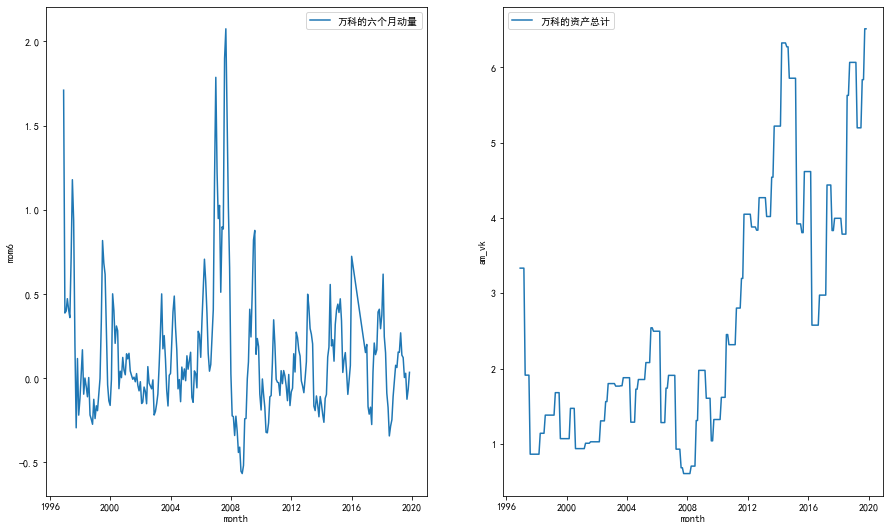

In [17]:
# 打印结果
print("万科公司2019年1月动量值为：{:.2f}、AM的值为：{:.2f}".format(mom_6.loc[201901, '000002'], am.loc[201901, '000002']))

mom6_vk = mom_6['000002'].astype(float)
print("万科公司动量的描述性统计：\n{}".format(mom6_vk.describe()))
print("样本个数：{}".format(len(mom6_vk)))
print("缺失值个数：{}".format(mom6_vk.isnull().sum()))

am_vk = am['000002'].astype(float)
print("万科公司资产总计的描述性统计：\n{}".format(am_vk.describe()))
print("样本个数：{}".format(len(am_vk)))
print("缺失值个数：{}".format(am_vk.isnull().sum()))

mom6_vk.name, am_vk.name = 'mom6', 'am_vk'
vk_data = pd.concat([mom6_vk, am_vk], axis=1).reset_index()
vk_data['month'] = pd.to_datetime(vk_data['index'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:-2]), format='%Y-%m-%d')

fig, ax = plt.subplots(1, 2, figsize=(15, 9))
sns.lineplot(x='month', y='mom6', data=vk_data, label='万科的六个月动量', ax=ax[0])
sns.lineplot(x='month', y='am_vk', data=vk_data, label='万科的资产总计', ax=ax[1])
plt.show()

In [21]:
# 列出2018年12月AM升序排序的第一组中前十只股票的AM值，并输出这十只股票在2019年1月的收益。
q5 = pd.concat([am.loc[201812, :], retA.loc[201901, :]], axis=1).dropna().reset_index()  # am[201812,:]与retA[201901,:]其实位于同一行
q5.columns = ['stkcd', 'am', 'ret']
q5 = q5.sort_values('am')
q5['month'] = 201901
q5_answer = pd.DataFrame(q5.iloc[:10, :])
q5_answer

,stkcd,am,ret,month
761,002306,0.039229,-4.4719,201901
187,000613,0.040428,-21.2754,201901
2451,600421,0.045025,15.8028,201901
13,000017,0.049691,-7.4635,201901
2833,600870,0.050263,-7.6316,201901
2852,600890,0.052288,-10.6441,201901
101,000503,0.073456,-12.9704,201901
2743,600769,0.077471,0.3887,201901
3227,603288,0.077661,4.9631,201901
1725,300357,0.087954,4.7691,201901


In [36]:
# 列出2018年12月AM升序排序的10组投资组合和多空组合在2019年1月的月度收益。
# 本函数返回分组排序的收益时间序列
def get_group(factor, size, ret, group_num=10):
    # factor = am
    # ret = retA
    # group_num = 10
    months = ret.index
    dfew = pd.DataFrame(columns=list(range(1, group_num + 1)), index=ret.index)
    dfvw = pd.DataFrame(columns=list(range(1, group_num + 1)), index=ret.index)
    for m, month in enumerate(months):
        # final:某个月3000多家股票的am,size,return
        # 每月final非空列数不同，即每月参与构造投资组合的公司数量不同(<=3873)
        final = pd.concat([factor.iloc[m, :], size.iloc[m, :], ret.iloc[m, :]], join='inner', axis=1)  # 注意此处的retA已调整一期！
        final.columns = ['factor', 'size', 'ret']
        final = final.dropna()

        if len(final) <= 10:
            continue  # continue相当于过滤掉len(final)小于10的月份，因为无法分为10组
        else:
            final = final.sort_values(by='factor')
            final['VW'] = final.apply(lambda x: x['size'] * x['ret'], axis=1)

            # p:确定的10个区间（某一月的所有股票，依据am）。11个数构成10个区间，上下限为[-inf,inf]
            p = [float('-inf')]
            for i in range(1, group_num):
                p.append(np.percentile(final['factor'], 100 / group_num * i))
            p.append(float('inf'))

            # total:将300列该月am分配到十个区间内,每组37家(以第一月为例)
            # k: 10个total的组合，len(k)=10
            k = []
            for i in range(group_num):
                total = final[(final['factor'] >= p[i]) & (final['factor'] <= p[i + 1])]
                k.append(total)

        # dfew:某月某组内30多家企业的回报率均值（等权收益）
        # dfvw:某月某组的按照size加权的回报率（加权收益）
        for j in range(group_num):
            dfew.iloc[m, j] = k[j]['ret'].mean()
            dfvw.iloc[m, j] = k[j]['VW'].sum() / k[j]['size'].sum()
    dfew['high-low'] = dfew[group_num] - dfew[1]
    dfvw['high-low'] = dfvw[group_num] - dfvw[1]
    dfew = dfew.astype(float)
    dfvw = dfvw.astype(float)
    return dfew, dfvw


# 打印结果
am_ew, am_vw = get_group(am, size, retA, 10)
print('am因子2019年1月的等权收益（10个投资组合和多空组合）：\n{}'.format(am_ew.loc[201901, :]))
print('am因子2019年1月的加权收益（10个投资组合和多空组合）：\n{}'.format(am_vw.loc[201901, :]))

am因子2019年1月的等权收益（10个投资组合和多空组合）：
1          -2.498574
2          -2.681763
3          -3.729409
4          -2.821602
5          -2.667129
6          -2.168756
7          -1.976353
8          -2.448221
9          -1.970863
10         -0.246918
high-low    2.251656
Name: 201901.0, dtype: float64
am因子2019年1月的加权收益（10个投资组合和多空组合）：
1           4.672605
2           0.571283
3          -1.931202
4           4.574606
5           0.055867
6          -0.584537
7           1.754051
8           2.365379
9           1.259252
10          5.662565
high-low    0.989959
Name: 201901.0, dtype: float64


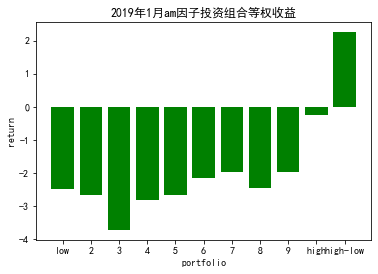

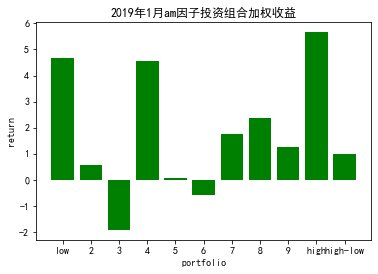

In [37]:
# 绘制2018年12月AM升序排序的10组投资组合和多空组合在2019年1月的月度收益。

y = list(am_ew.loc[201901, :])
x = ['low', '2', '3', '4', '5', '6', '7', '8', '9', 'high', 'high-low']
plt.title('2019年1月am因子投资组合等权收益')
plt.xlabel('portfolio')
plt.ylabel('return')
plt.bar(x, y, color='green')
plt.show()
y = list(am_vw.loc[201901, :])
x = ['low', '2', '3', '4', '5', '6', '7', '8', '9', 'high', 'high-low']
plt.title('2019年1月am因子投资组合加权收益')
plt.xlabel('portfolio')
plt.ylabel('return')
plt.bar(x, y, color='green')
plt.show() 

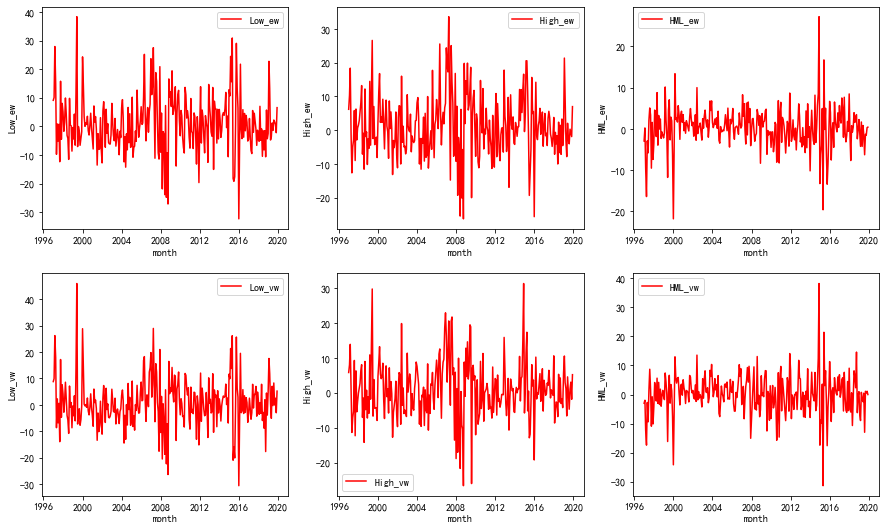

In [59]:
# 绘制1997年1月至2019年12月的10个分位组合的时序收益。
# x轴为月，y轴为10个分位组合的收益。计算投资组合收益可以按照等权重或市值加权计算。(ew U vw =ev)
def timeseries_return_plot(factor_ew, factor_vw):
    factor_ev = pd.concat([factor_ew.loc[:, [1, 10, 'high-low']], factor_vw.loc[:, [1, 10, 'high-low']]], axis=1).reset_index()
    factor_ev.columns = ['month', 'Low_ew', 'High_ew', 'HML_ew', 'Low_vw', 'High_vw', 'HML_vw']
    # 若不pd.to_datetime处理month格式，画出图形的效果不连续
    factor_ev['month'] = pd.to_datetime(factor_ev['month'].apply(lambda x: str(x)[: 4] + '-' + str(x)[4:-2]))  # -2是因为小数点也占位
    fig, ax = plt.subplots(2, 3, figsize=(15, 9))
    for i in range(2):
        for j in range(3):
            sns.lineplot(x='month', y=factor_ev.iloc[:, 3 * i + j + 1], label=factor_ev.columns[3 * i + j + 1],
                         data=factor_ev, ax=ax[i, j], color='red')  # label不能用am_ev.iloc[:,x],会显示该列所有数
    plt.show()


timeseries_return_plot(am_ew, am_vw)
# timeseries_return_plot(mom_6_ew, mom_6_vw)
# timeseries_return_plot(illq_ew, illq_vw)（报告中呈现了illq的结果）
# timeseries_return_plot(ag_ew, ag_vw)
# timeseries_return_plot(operprof_ew, operprof_vw)

In [66]:
"""
列出整个投资期内，10个分位数投资组合和多空组合的平均收益、经过Newey-West调整的t值、
未经过Newey-West调整的t值、夏普比率、经过CAPM和FF3模型调整后的alpha及NW调整的t值。
"""
# NW-t检验
def NWtest(a, lags=5):
    """
    :param a: a=data['factor'], series
    :param lags: 5
    :return:
    """
    adj_a = pd.DataFrame(a)
    adj_a = adj_a.dropna()
    if len(adj_a) > 0:
        adj_a = adj_a.astype(float)
        adj_a = np.array(adj_a)

        # cov_kwds滞后项:NW调整对多个regressors的回归系数的标准误同时修正，增强结果稳健性
        # 为什么是[1]*len(adj_a)？？？
        model = sm.OLS(adj_a, [1] * len(adj_a)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
        return float(model.tvalues), float(model.pvalues)
    else:
        return [np.nan] * 2


# 几项检验的计算方法
def performance_valuation(vb, factor3):
    """
    :param vb: vb = dfew[v]; type: series; 各月份在11种投资组合的回报率,range(v)=low,1,2...high,h-l。
    :param factor3: factor3 = ff5 (风险溢价、市值、账面市值、盈利、投资)五因子
    :return: final.iloc[:, 0] ; type: series, len=8

    函数调用方式（难点：注意为循环11种投资组合调用）
    for i, v in enumerate(vbsew):
        resultew.iloc[i, 0] = v
        print(dfew[v])  # 可注释本行取消输出中间过程
        performance_valuation(dfew[v], factor3)
    """
    vb = vb.dropna()
    data = pd.concat([vb, factor3], axis=1, join='inner')
    data.columns = ['factor', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma', 'rf']

    # 均值
    a = round(np.mean(data['factor']), 2)

    # t检验
    t = round(NWtest(data['factor'])[0], 2)  # NW调整后的t值
    t0 = round(stats.ttest_1samp(data['factor'], 0)[0], 2)  # 未经NW调整后的t值

    # 夏普比率
    std = np.std(data['factor'])
    spr = round(np.mean(data['factor']) / std * np.sqrt(12), 2)

    # a检验
    camp = smf.ols('factor ~ mkt_rf', data).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    c_a = round(camp.params[0], 2)
    c_t = round(camp.tvalues[0], 2)

    ff3_model = smf.ols('factor ~ mkt_rf+smb+hml', data).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    # 此处可以考虑画出ols的回归曲线图
    ff3_a = round(ff3_model.params[0], 2)
    ff3_t = round(ff3_model.tvalues[0], 2)

    final = pd.DataFrame([a, t, t0, spr, c_a, c_t, ff3_a, ff3_t])
    return final.iloc[:, 0]


# 整合整个投资期内各投资组合的所有检验值
def get_uni_test(ret, size, factor, factor3):
    # df_ev存放各月各投资组合的收益
    dfew, dfvw = get_group(factor, size, ret)

    resultew = pd.DataFrame(columns=['portfolio', 'return', 'NWt', 't', 'spr', 'camp_a', 'camp_t', 'ff3_a', 'ff3_t'],
                            index=list(range(11)))
    resultvw = pd.DataFrame(columns=['portfolio', 'return', 'NWt', 't', 'spr', 'camp_a', 'camp_t', 'ff3_a', 'ff3_t'],
                            index=list(range(11)))

    # vds_ev用于存放投资组合分位数的类型,如1，2...high-low
    vbsew = dfew.columns
    vbsvw = dfvw.columns

    for i, v in enumerate(vbsew):
        resultew.iloc[i, 0] = v
        # 重点填充部分:循环调用performance_valuation函数
        resultew.iloc[i, 1:] = performance_valuation(dfew[v], factor3).values

    for i, v in enumerate(vbsvw):
        resultvw.iloc[i, 0] = v
        resultvw.iloc[i, 1:] = performance_valuation(dfvw[v], factor3).values

    resultew.iloc[:, 0] = ['low', '2', '3', '4', '5', '6', '7', '8', '9', 'high', 'high-low']
    resultew = resultew.set_index('portfolio')
    resultvw.iloc[:, 0] = ['low', '2', '3', '4', '5', '6', '7', '8', '9', 'high', 'high-low']
    resultvw = resultvw.set_index('portfolio')

    return resultew, resultvw


results_mom_ew, results_mom_vw = get_uni_test(retA, size, mom_6, ff5)
print("mom6单因子检验等权结果：\n{}".format(results_mom_ew))
print("mom6单因子检验加权结果：\n{}".format(results_mom_vw))

# results_am_ew, results_am_vw = get_uni_test(retA, size, am, ff5)
# print("am单因子检验等权结果：\n{}".format(results_am_ew))
# print("am单因子检验加权结果：\n{}".format(results_am_vw))

# results_illq_ew, results_illq_vw = get_uni_test(retA, size, illq, ff5)
# print("illq单因子检验等权结果：\n{}".format(results_illq_ew))
# print("illq单因子检验加权结果：\n{}".format(results_illq_vw))

mom6单因子检验等权结果：
          return   NWt     t   spr camp_a camp_t ff3_a ff3_t
portfolio                                                   
low         1.04  1.53  1.69  0.35   0.27   0.93 -0.43 -2.37
2           1.13  1.65  1.91   0.4   0.36   1.48 -0.36 -2.72
3           1.43  2.03  2.44  0.51   0.67   2.46 -0.05 -0.44
4           1.44   2.1  2.47  0.52   0.68   2.66 -0.08 -0.76
5           1.38     2  2.37  0.49   0.62   2.46 -0.16 -1.49
6           1.32  1.97  2.31  0.48   0.57   2.36 -0.15 -1.52
7            1.3  1.98  2.29  0.48   0.54   2.42 -0.14 -1.26
8           1.18   1.8  2.09  0.44   0.43   1.95 -0.21 -1.64
9           1.16   1.8  2.07  0.43   0.41    1.9 -0.13 -0.89
high         0.9  1.46  1.58  0.33   0.17    0.7 -0.29  -1.3
high-low   -0.14 -0.51 -0.46  -0.1   -0.1  -0.36  0.14  0.47
mom6单因子检验加权结果：
          return   NWt     t   spr camp_a camp_t ff3_a ff3_t
portfolio                                                   
low         0.68  0.99  1.17  0.24   -0.1  -0.41 -0.35 

In [ ]:
# 为什么用NW调整的t值？请查阅资料。并与非NW调整的t值进行比较。
"""
当残差存在异方差或者自相关时，OLS 得到的 β 的方差的估计是不准确的，从而影响对 β 进行统计检验。
在时序 OLS 回归中，Newey-West 调整同时作用于多个 regressors 的回归系数，从而求出 b 的协方差矩阵。
如果序列存在异方差和自相关特性，使得对其标准差的估计存在偏差，从而导致因子显著性检验结果失真。
Newey-West调整通过在计算协方差矩阵时加入自相关调整项，能够有效规避序列自相关对协方差矩阵估计带来的影响，增强稳健性。
"""

# 与非NW调整的t值进行比较
"""
t与t0比较，经过NW调整的t值一般比未调整的t值更小，说明NW调整能够降低数据“虚假的有效”。
# 此处可以将t与t0列可视化
"""

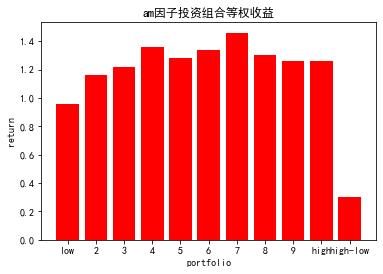

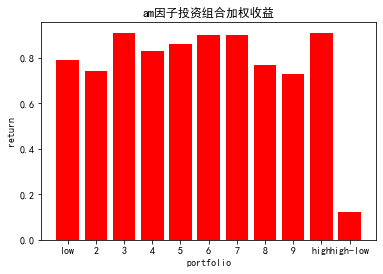

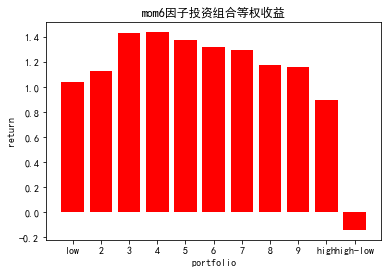

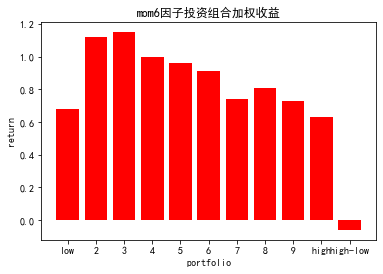

In [44]:
# 观察动量因子和AM因子的分组收益和多空组合收益，是否随着因子的增大而收益增大？参考"投资学"绘制柱形图。
def bar(data, titlename):
    # data = results_am_ew
    data = data.astype(float)
    plt.clf()  # 清除当前figure的所有axes，但是不关闭这个window，所以能继续复用于其他的plot
    y = list(data.iloc[:, 0])
    x = list(data.index)

    plt.title(titlename)
    plt.xlabel('portfolio')
    plt.ylabel('return')
    c = plt.bar(x, y, color='red')
    c = plt.show()

    return c


# bar_illq_ew = bar(results_illq_ew, 'illq因子投资组合等权收益')
# bar_illq_vw = bar(results_illq_vw, 'illq因子投资组合加权收益')
bar_am_ew = bar(results_am_ew, 'am因子投资组合等权收益')
bar_am_vw = bar(results_am_vw, 'am因子投资组合加权收益')
bar_mom_ew = bar(results_mom_ew, 'mom6因子投资组合等权收益')
bar_mom_vw = bar(results_mom_vw, 'mom6因子投资组合加权收益')

In [64]:
# bar_illq_ew = bar(results_illq_ew, 'illq因子投资组合等权收益')
# bar_illq_vw = bar(results_illq_vw, 'illq因子投资组合加权收益')

In [45]:
# 问题十一：列出等权（和市值加权）情况下均能取得显著多空组合收益的因子，列出这些因子以及采用这些因子进行投资的绩效评估结果。
file = glob.glob(os.path.join(path, '数据', '96个因子', '*.csv'))  # glob.glob()将会匹配给定路径下的所有pattern

name_list = []  # 因子名称
for i in range(len(file)):
    name_list.append(file[i][36: -4])

k = []  # 15个因子数据框:[df,df,...]
for i in range(len(file)):
    k.append(pd.read_csv(file[i]))


# 修改数据格式:变成宽表
"""
样本为所有A股股票，样本区间为199612-201911，收益区间为199701-201912。 
作业需要收集因子：Github数据区间截止2018年底，可以将两个因子截至相同时间（2018年底）。
"""
def change(k):
    k_index = size.index[:263]
    k2 = []
    for i in range(len(k)):
        # i = 0
        k0 = k[i].iloc[:263, :]
        k0 = k0.iloc[:, 1:].T
        k0 = k0.reset_index()
        k0.loc[:, 'index'] = k0.loc[:, 'index'].apply(lambda x: str(int(x)).zfill(6))
        k0 = k0.set_index('index')
        k0 = k0.iloc[:, 0:].T
        k0.index = k_index
        k2.append(k0)

    return k2


k2 = change(k)

# 将股票收益率数据与因子格式统一
ret_fin = pd.concat([pd.DataFrame(columns=k2[0].columns), retA.iloc[:263, :]], axis=0, join='inner')

# 汇总各因子10-1组结果
ew_HL = pd.DataFrame(index=name_list, columns=['return', 'NWt', 't', 'spr', 'capm_a', 'capm_t', 'ff3_a', 'ff3_t'])
vw_HL = pd.DataFrame(index=name_list, columns=['return', 'NWt', 't', 'spr', 'capm_a', 'capm_t', 'ff3_a', 'ff3_t'])

for i in range(len(file)):
    # i = 0
    factor = k2[i]
    k_results_ew, k_results_vw = get_uni_test(ret_fin, k2[0], factor, ff5)
    ew_HL.iloc[i, :] = k_results_ew.iloc[-1, :]  # 取最后一列，即“多空组合”
    vw_HL.iloc[i, :] = k_results_vw.iloc[-1, :]
    print(i)

ew_HL.to_csv(os.path.join(path, '过程数据', '等权95.csv'))
vw_HL.to_csv(os.path.join(path, '过程数据', '加权95.csv'))

ew_HL = pd.read_csv(os.path.join(path, '过程数据', '等权95.csv'), header=0, index_col=0)
vw_HL = pd.read_csv(os.path.join(path, '过程数据', '加权95.csv'), header=0, index_col=0)

ew_sig = ew_HL[abs(ew_HL['NWt']) >= 1.96]
vw_sig = vw_HL[abs(vw_HL['NWt']) >= 1.96]

commonew = ew_sig[ew_sig.index.isin(vw_sig.index)].sort_values(by='NWt', ascending=False)  # 降序
commonvw = vw_sig[vw_sig.index.isin(ew_sig.index)].sort_values(by='NWt', ascending=False)

print("显著的因子——等权：\n{}".format(commonew))
print("显著的因子——加权：\n{}".format(commonvw))

# 存储显著因子
out_path = os.path.join(path, '显著因子')

if not os.path.exists(out_path):
    os.mkdir(out_path)  # 创建存放显著因子的文件夹

files2 = glob.glob(os.path.join(path, '显著因子', '*.csv'))
for f in files2:
    os.remove(f)  # 删除该文件夹下的原有csv

for sig in commonew.index:
    shutil.copy(os.path.join(path, '数据', '96个因子', sig + '.csv'), out_path)  # 从15个因子的文件夹copy显著因子到out_path


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
显著的因子——等权：
             return   NWt     t   spr  capm_a  capm_t  ff3_a  ff3_t
15_illq        1.33  3.33  3.34  0.72     NaN     NaN   0.19   1.21
01_size       -2.37 -3.67 -4.09 -0.88     NaN     NaN  -0.87  -2.21
07_vol        -1.06 -3.72 -3.26 -0.70     NaN     NaN  -1.42  -5.04
13_volumed    -1.99 -5.44 -5.60 -1.20     NaN     NaN  -0.97  -5.66
12_std_turn   -2.14 -7.21 -6.51 -1.40     NaN     NaN  -2.69  -8.87
14_std_vol    -3.23 -9.20 -8.78 -1.88     NaN     NaN  -2.41  -9.79
显著的因子——加权：
             return   NWt     t   spr  capm_a  capm_t  ff3_a  ff3_t
15_illq        0.92  2.01  2.01  0.43     NaN     NaN  -0.37  -2.17
07_vol        -1.11 -2.95 -2.83 -0.61     NaN     NaN  -1.59  -4.25
01_size       -1.88 -3.26 -3.21 -0.69     NaN     NaN  -0.21  -0.86
13_volumed    -1.52 -3.47 -3.55 -0.76     NaN     NaN  -0.27  -1.80
12_std_turn   -1.87 -4.51 -4.58 -0.98     NaN     NaN  -2.66  -6.63
14_std_vol    -2.11 -5.05 -4.78 -1.03     NaN  

In [46]:
commonew  # 等权收益显著因子排序

,return,NWt,t,spr,capm_a,capm_t,ff3_a,ff3_t
15_illq,1.33,3.33,3.34,0.72,NaN,NaN,0.19,1.21
01_size,-2.37,-3.67,-4.09,-0.88,NaN,NaN,-0.87,-2.21
07_vol,-1.06,-3.72,-3.26,-0.70,NaN,NaN,-1.42,-5.04
13_volumed,-1.99,-5.44,-5.60,-1.20,NaN,NaN,-0.97,-5.66
12_std_turn,-2.14,-7.21,-6.51,-1.40,NaN,NaN,-2.69,-8.87
14_std_vol,-3.23,-9.20,-8.78,-1.88,NaN,NaN,-2.41,-9.79


In [47]:
commonvw  # 加权收益显著因子排序

,return,NWt,t,spr,capm_a,capm_t,ff3_a,ff3_t
15_illq,0.92,2.01,2.01,0.43,NaN,NaN,-0.37,-2.17
07_vol,-1.11,-2.95,-2.83,-0.61,NaN,NaN,-1.59,-4.25
01_size,-1.88,-3.26,-3.21,-0.69,NaN,NaN,-0.21,-0.86
13_volumed,-1.52,-3.47,-3.55,-0.76,NaN,NaN,-0.27,-1.80
12_std_turn,-1.87,-4.51,-4.58,-0.98,NaN,NaN,-2.66,-6.63
14_std_vol,-2.11,-5.05,-4.78,-1.03,NaN,NaN,-1.00,-5.17
